# Review: Aleatoric vs. Epistemic Uncertainty using Monte-Carlo Dropout

## 0. Libraries & Setup

In [2]:
# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

# data
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# other
import tqdm as tqdm

Setup the device for the training:

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


Finally, a function that contains some noise:

In [4]:
# Define the function to be modeled
def f(x):
    return x + np.random.normal(0, 0.1, x.shape[0]) * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

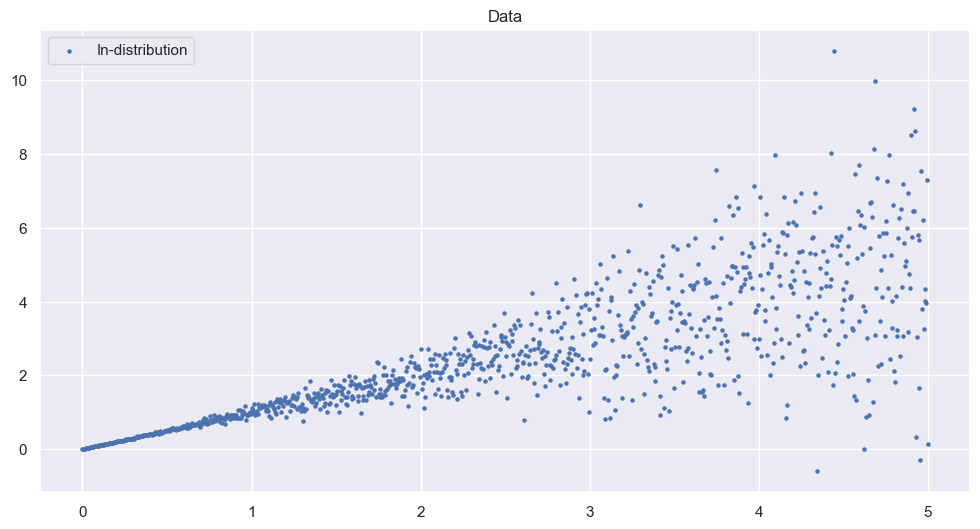

In [5]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

The function is linear with some Gaussian noise added to it that increases with the input value (cone shape).

In [6]:
# Make batch data 
def make_batch(data_size, sample_size, data_x, data_y):
    # Make batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, 1])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i]]
        batch_y[i,:] = data_y[batch_idx[i]] 
    
    batch_x = torch.FloatTensor(batch_x).to(device)
    batch_y = torch.FloatTensor(batch_y).to(device)
    
    return batch_x, batch_y  

## I. Splitting Aleatoric and Epistemic Uncertainty using MC Dropout

As mentioned in the previous notebooks, there are two kinds of uncertainties: aleatoric and epistemic. The first one is related to the noise in the data, while the second one is related to the model's uncertainty about the data. In this notebook, we will see how to split these two kinds of uncertainties using Monte-Carlo Dropout. The following paper is used as a reference: [A Deeper Look into Aleatoric and Epistemic Uncertainty Disentanglement](https://arxiv.org/pdf/2204.09308.pdf)

### I.1. MC Dropout implementation

In [49]:
class MC_Dropout_net(nn.Module):
    def __init__(self, p: int = 0.25) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        
        # instead of outputting a single value, we output two values
        # the mean and the std of the distribution
        self.fc_mu = nn.Linear(32, 1)
        self.fc_sigma = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        mu = self.fc_mu(x)
        var = self.fc_sigma(x)
        return mu, var

Setup some training parameters:

In [50]:
model = MC_Dropout_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))

Training loop:

In [51]:
for i in tqdm.tqdm(range(10_000)): 
    # model_list[iter].train() 
    # create batch
    batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
    
    # forward pass
    mu_train, log_var_train = model(batch_x)
    
    # compute loss
    loss = torch.mean(
        0.5 * log_var_train + \
        0.5 * (torch.square(batch_y - mu_train)/torch.exp(log_var_train))) + 1
    
    # zero grad
    optimizer.zero_grad()

    # backward pass
    loss.backward()

    # step
    optimizer.step()
    

    # print each 500 epochs
    if i % 200 == 0:
        print(f"Epoch: {i}, train loss: {loss.item():.4f}")

  0%|          | 12/10000 [00:00<02:45, 60.33it/s]

Epoch: 0, train loss: 6.7820


  2%|▏         | 218/10000 [00:02<01:41, 96.10it/s]

Epoch: 200, train loss: 1.6306


  4%|▍         | 412/10000 [00:04<01:36, 99.74it/s]

Epoch: 400, train loss: 1.3269


  6%|▌         | 616/10000 [00:06<01:33, 100.00it/s]

Epoch: 600, train loss: 1.1788


  8%|▊         | 818/10000 [00:08<01:31, 100.24it/s]

Epoch: 800, train loss: 1.4867


 10%|█         | 1018/10000 [00:10<01:29, 100.68it/s]

Epoch: 1000, train loss: 1.3294


 12%|█▏        | 1211/10000 [00:12<01:27, 100.22it/s]

Epoch: 1200, train loss: 1.2886


 14%|█▍        | 1412/10000 [00:14<01:28, 97.03it/s] 

Epoch: 1400, train loss: 0.8452


 16%|█▌        | 1612/10000 [00:16<01:24, 99.46it/s]

Epoch: 1600, train loss: 0.9611


 18%|█▊        | 1813/10000 [00:18<01:22, 99.21it/s]

Epoch: 1800, train loss: 1.1787


 20%|██        | 2017/10000 [00:20<01:19, 100.13it/s]

Epoch: 2000, train loss: 0.9938


 22%|██▏       | 2213/10000 [00:22<01:18, 99.44it/s] 

Epoch: 2200, train loss: 0.8031


 24%|██▍       | 2415/10000 [00:24<01:16, 99.63it/s]

Epoch: 2400, train loss: 1.1172


 26%|██▌       | 2618/10000 [00:26<01:14, 99.58it/s]

Epoch: 2600, train loss: 1.4055


 28%|██▊       | 2815/10000 [00:28<01:12, 99.77it/s] 

Epoch: 2800, train loss: 1.1109


 30%|███       | 3006/10000 [00:30<01:29, 77.75it/s]

Epoch: 3000, train loss: 1.0415


 32%|███▏      | 3213/10000 [00:33<01:13, 92.09it/s]

Epoch: 3200, train loss: 1.3321


 34%|███▍      | 3411/10000 [00:35<01:10, 93.94it/s]

Epoch: 3400, train loss: 0.9363


 36%|███▌      | 3611/10000 [00:37<01:09, 92.15it/s]

Epoch: 3600, train loss: 0.8527


 38%|███▊      | 3811/10000 [00:39<01:03, 96.86it/s]

Epoch: 3800, train loss: 1.1297


 40%|████      | 4017/10000 [00:41<00:59, 99.98it/s] 

Epoch: 4000, train loss: 1.0522


 42%|████▏     | 4217/10000 [00:43<00:58, 99.34it/s] 

Epoch: 4200, train loss: 1.0992


 44%|████▍     | 4419/10000 [00:45<00:56, 99.06it/s]

Epoch: 4400, train loss: 0.6380


 46%|████▌     | 4616/10000 [00:47<00:55, 97.28it/s] 

Epoch: 4600, train loss: 0.8255


 48%|████▊     | 4816/10000 [00:49<00:52, 98.05it/s]

Epoch: 4800, train loss: 0.8311


 50%|█████     | 5018/10000 [00:51<00:50, 99.50it/s]

Epoch: 5000, train loss: 1.2510


 52%|█████▏    | 5213/10000 [00:53<00:48, 99.72it/s]

Epoch: 5200, train loss: 0.4201


 54%|█████▍    | 5421/10000 [00:55<00:45, 99.87it/s] 

Epoch: 5400, train loss: 1.0028


 56%|█████▌    | 5613/10000 [00:57<00:43, 100.01it/s]

Epoch: 5600, train loss: 1.3389


 58%|█████▊    | 5817/10000 [00:59<00:42, 99.58it/s] 

Epoch: 5800, train loss: 1.2456


 60%|██████    | 6013/10000 [01:01<00:40, 98.02it/s]

Epoch: 6000, train loss: 0.8799


 62%|██████▏   | 6214/10000 [01:03<00:39, 96.42it/s]

Epoch: 6200, train loss: 1.4316


 64%|██████▍   | 6416/10000 [01:05<00:36, 99.34it/s]

Epoch: 6400, train loss: 1.0875


 66%|██████▌   | 6612/10000 [01:07<00:33, 100.04it/s]

Epoch: 6600, train loss: 0.8295


 68%|██████▊   | 6818/10000 [01:09<00:32, 99.38it/s] 

Epoch: 6800, train loss: 1.2178


 70%|███████   | 7019/10000 [01:11<00:29, 101.09it/s]

Epoch: 7000, train loss: 0.8590


 72%|███████▏  | 7216/10000 [01:13<00:27, 99.70it/s] 

Epoch: 7200, train loss: 0.8794


 74%|███████▍  | 7417/10000 [01:16<00:26, 98.98it/s]

Epoch: 7400, train loss: 0.9624


 76%|███████▌  | 7612/10000 [01:17<00:23, 99.89it/s]

Epoch: 7600, train loss: 0.9712


 78%|███████▊  | 7812/10000 [01:20<00:22, 97.34it/s]

Epoch: 7800, train loss: 0.8320


 80%|████████  | 8013/10000 [01:22<00:19, 99.41it/s]

Epoch: 8000, train loss: 1.1558


 82%|████████▏ | 8218/10000 [01:24<00:18, 96.47it/s]

Epoch: 8200, train loss: 0.9782


 84%|████████▍ | 8411/10000 [01:26<00:16, 98.96it/s]

Epoch: 8400, train loss: 1.0170


 86%|████████▌ | 8615/10000 [01:28<00:13, 99.27it/s]

Epoch: 8600, train loss: 0.8220


 88%|████████▊ | 8818/10000 [01:30<00:11, 99.03it/s]

Epoch: 8800, train loss: 0.6965


 90%|█████████ | 9011/10000 [01:32<00:10, 98.79it/s]

Epoch: 9000, train loss: 0.9334


 92%|█████████▏| 9211/10000 [01:34<00:08, 97.24it/s]

Epoch: 9200, train loss: 0.8172


 94%|█████████▍| 9411/10000 [01:36<00:05, 98.70it/s]

Epoch: 9400, train loss: 1.0291


 96%|█████████▌| 9615/10000 [01:38<00:03, 99.42it/s]

Epoch: 9600, train loss: 0.8872


 98%|█████████▊| 9811/10000 [01:40<00:01, 99.67it/s]

Epoch: 9800, train loss: 0.7536


100%|██████████| 10000/10000 [01:42<00:00, 97.65it/s]


In [52]:
samples = 10_000
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

mu_arr = np.zeros([X_sample_tensor.shape[0], samples])
var_arr = np.zeros([X_sample_tensor.shape[0], samples])

with torch.no_grad():
    for i in range(samples):
        mu_pred, var_pred = model(X_sample_tensor)
        # positivity constraint
        # sigma_pred_pos = torch.log(1 + torch.exp(sigma_pred)) + 1e-6
        
        mu_sample = mu_pred.cpu().detach().numpy()
        var_sample_log =  var_pred.cpu().detach().numpy()
        
        
        mu_arr[:, i] = np.reshape(mu_sample, (X_sample_tensor.shape[0]))
        var_arr[:, i] = np.reshape(var_sample_log, (X_sample_tensor.shape[0]))

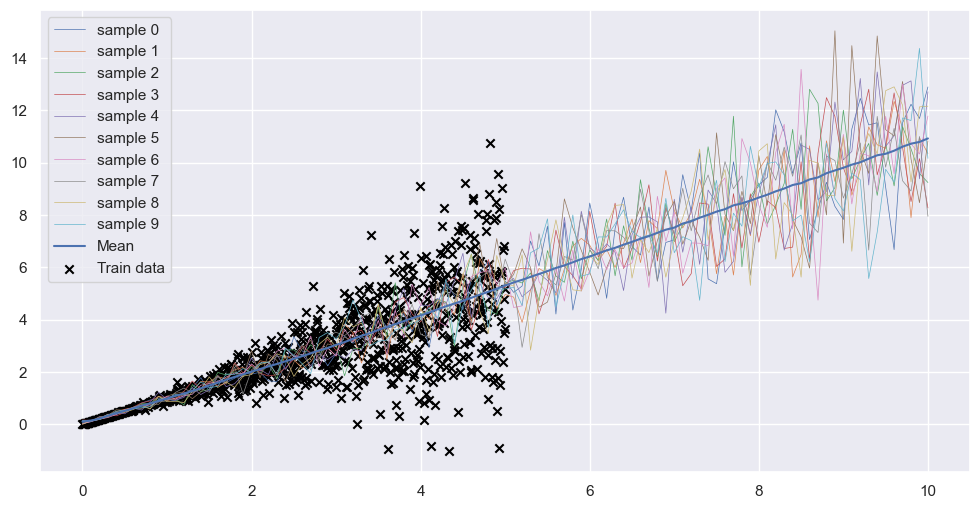

In [53]:
# plot 10 samples on the same figure
sns.set(rc={'figure.figsize':(12, 6)})
for i in range(10):
    plt.plot(x_sample, mu_arr[:, i], linewidth=0.5, label=f'sample {i}')
plt.plot(x_sample, np.mean(mu_arr, axis=1), linewidth=1.5, label='Mean')

# plot data
plt.scatter(X, y, marker='x', color='black', label='Train data')
plt.legend()
plt.show()

### I.2 Uncertainty estimation

In [54]:
var_arr = np.exp(var_arr)

mean_hat = np.mean(mu_arr, axis=1)
var_hat = np.mean(var_arr + np.square(mu_arr), axis=1) - np.square(mean_hat)

std_hat = np.sqrt(var_hat)

In [55]:
uncertainty_aleatoric = np.mean(var_arr, axis=1)
uncertainty_epistemic = np.var(mu_arr, axis=1)

uncertainty_aleatoric_std = np.sqrt(uncertainty_aleatoric)
uncertainty_epistemic_std = np.sqrt(uncertainty_epistemic)

uncertainty_total = np.sqrt(uncertainty_aleatoric + uncertainty_epistemic)

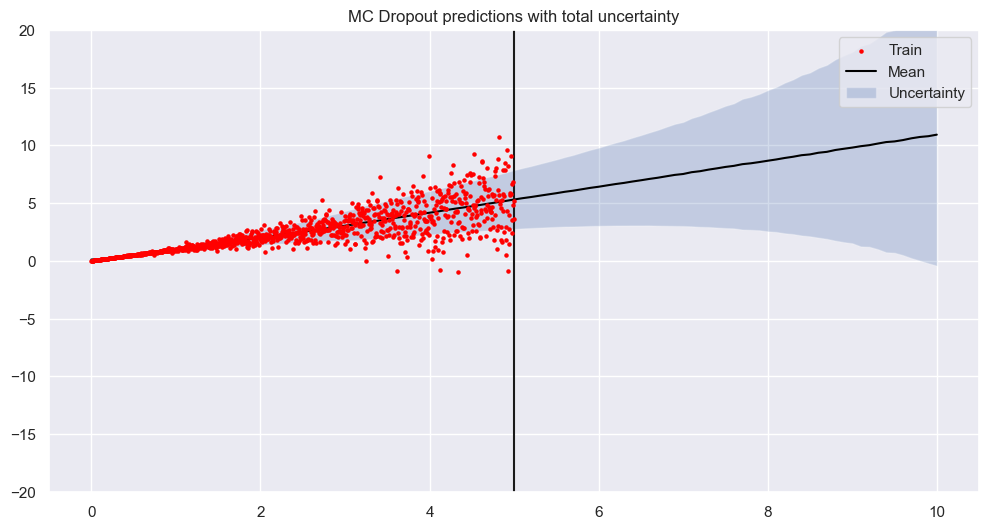

In [56]:
# plot predictions with confidence intervals
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")

plt.fill_between(x_sample, mean_hat - uncertainty_total, mean_hat + uncertainty_total, alpha=0.25, label='Uncertainty')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('MC Dropout predictions with total uncertainty')
plt.show()

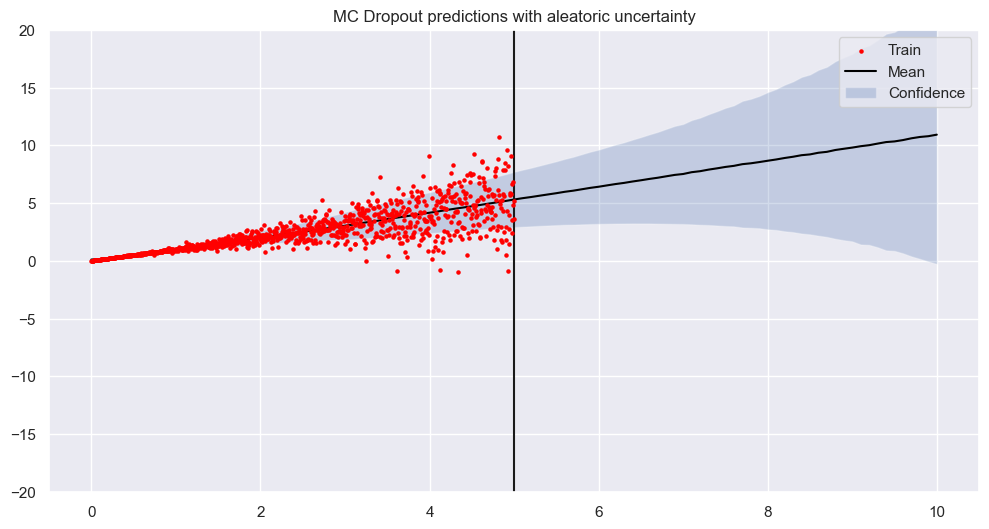

In [57]:
# plot predictions with confidence intervals, aleatoric uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label='Confidence')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('MC Dropout predictions with aleatoric uncertainty')
plt.show()

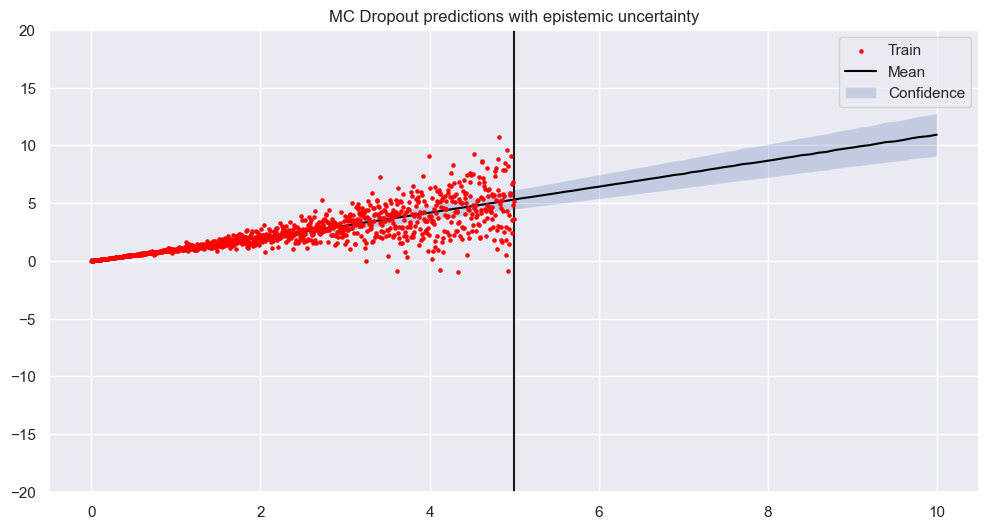

In [58]:
# plot predictions with confidence intervals, epistemic uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_epistemic_std, mean_hat + uncertainty_epistemic_std, alpha=0.25, label='Confidence')
plt.plot(X, y, 'b.', label='Training data')
plt.ylim([-20, 20])
plt.axvline(x=10, color='k')
plt.legend()
plt.title('MC Dropout predictions with epistemic uncertainty')
plt.show()

This time, compared to the notebook "01 - MC dropout", aleatoric uncertainty is better estimated:

In [59]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

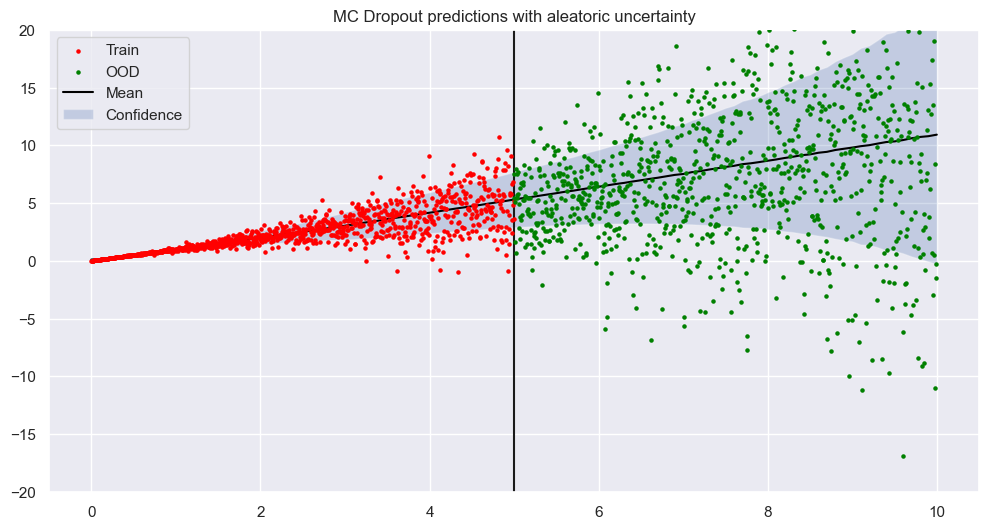

In [60]:
# plot predictions with confidence intervals, aleatoric uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label='Confidence')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('MC Dropout predictions with aleatoric uncertainty')
plt.show()

### I.3 Without data noise

Let's remove noise from the data and see what happens:

In [61]:
# Define the function to be modeled
def f(x):
    return x + 0.1 * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

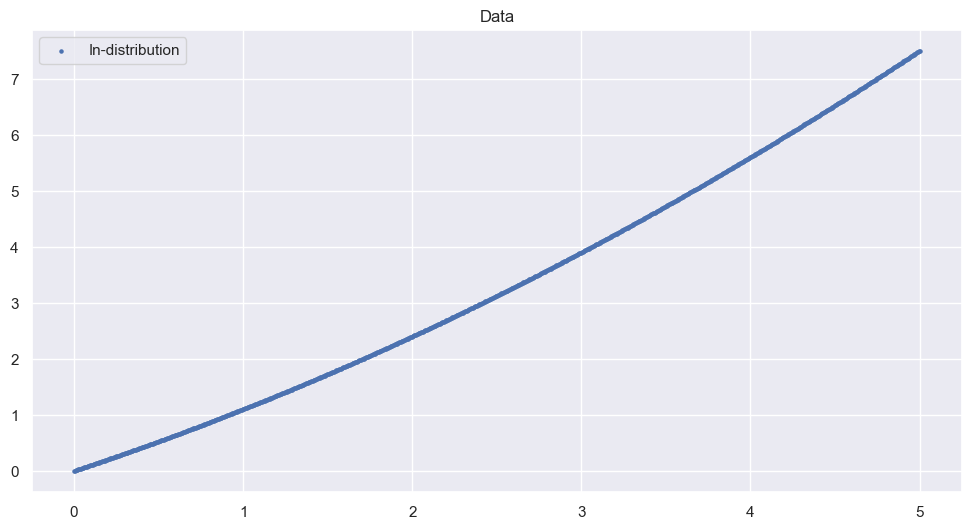

In [62]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

Let's train the model on the data:

In [63]:
for i in tqdm.tqdm(range(10_000)): 
    # model_list[iter].train() 
    # create batch
    batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
    
    # forward pass
    mu_train, log_var_train = model(batch_x)
    
    # compute loss
    loss = torch.mean(
        0.5 * log_var_train + \
        0.5 * (torch.square(batch_y - mu_train)/torch.exp(log_var_train))) + 1
    
    # zero grad
    optimizer.zero_grad()

    # backward pass
    loss.backward()

    # step
    optimizer.step()
    

    # print each 500 epochs
    if i % 200 == 0:
        print(f"Epoch: {i}, train loss: {loss.item():.4f}")

  0%|          | 15/10000 [00:00<02:12, 75.12it/s]

Epoch: 0, train loss: 1.2087


  2%|▏         | 210/10000 [00:02<01:50, 88.96it/s]

Epoch: 200, train loss: 0.5851


  4%|▍         | 410/10000 [00:04<01:44, 91.98it/s]

Epoch: 400, train loss: 0.4825


  6%|▌         | 614/10000 [00:06<01:40, 92.97it/s]

Epoch: 600, train loss: 0.6793


  8%|▊         | 812/10000 [00:09<01:41, 90.18it/s]

Epoch: 800, train loss: 0.4024


 10%|█         | 1013/10000 [00:11<01:39, 90.34it/s]

Epoch: 1000, train loss: 0.3954


 12%|█▏        | 1210/10000 [00:13<01:34, 93.47it/s]

Epoch: 1200, train loss: 0.3074


 14%|█▍        | 1412/10000 [00:15<01:26, 99.41it/s]

Epoch: 1400, train loss: 0.4571


 16%|█▌        | 1619/10000 [00:17<01:24, 99.34it/s]

Epoch: 1600, train loss: 0.4554


 18%|█▊        | 1818/10000 [00:19<01:22, 99.67it/s] 

Epoch: 1800, train loss: 0.7702


 20%|██        | 2019/10000 [00:22<01:25, 93.73it/s]

Epoch: 2000, train loss: 0.3529


 22%|██▏       | 2219/10000 [00:24<01:19, 97.28it/s]

Epoch: 2200, train loss: 0.5623


 24%|██▍       | 2419/10000 [00:26<01:18, 97.00it/s]

Epoch: 2400, train loss: 0.6223


 26%|██▌       | 2619/10000 [00:28<01:15, 97.27it/s]

Epoch: 2600, train loss: 0.4104


 28%|██▊       | 2818/10000 [00:30<01:15, 95.70it/s]

Epoch: 2800, train loss: 0.4513


 30%|███       | 3018/10000 [00:32<01:11, 97.20it/s]

Epoch: 3000, train loss: 0.5901


 32%|███▏      | 3218/10000 [00:34<01:09, 96.99it/s]

Epoch: 3200, train loss: 0.6609


 34%|███▍      | 3418/10000 [00:36<01:08, 96.24it/s]

Epoch: 3400, train loss: 0.6145


 36%|███▌      | 3618/10000 [00:38<01:04, 98.31it/s]

Epoch: 3600, train loss: 0.1477


 38%|███▊      | 3818/10000 [00:40<01:03, 96.79it/s]

Epoch: 3800, train loss: 0.7364


 40%|████      | 4017/10000 [00:43<01:02, 95.03it/s]

Epoch: 4000, train loss: 0.2492


 42%|████▏     | 4217/10000 [00:45<00:59, 97.60it/s]

Epoch: 4200, train loss: 0.5349


 44%|████▍     | 4417/10000 [00:47<00:58, 96.03it/s]

Epoch: 4400, train loss: 0.3121


 46%|████▌     | 4617/10000 [00:49<00:55, 97.55it/s]

Epoch: 4600, train loss: 0.9520


 48%|████▊     | 4817/10000 [00:51<00:52, 97.96it/s]

Epoch: 4800, train loss: 0.4430


 50%|█████     | 5017/10000 [00:53<00:51, 97.59it/s]

Epoch: 5000, train loss: 0.2217


 52%|█████▏    | 5216/10000 [00:55<00:48, 97.66it/s]

Epoch: 5200, train loss: 0.6648


 54%|█████▍    | 5416/10000 [00:57<00:47, 97.19it/s]

Epoch: 5400, train loss: 0.3659


 56%|█████▌    | 5616/10000 [00:59<00:45, 96.99it/s]

Epoch: 5600, train loss: 0.4223


 58%|█████▊    | 5818/10000 [01:01<00:44, 94.19it/s]

Epoch: 5800, train loss: 0.6738


 60%|██████    | 6018/10000 [01:03<00:42, 94.48it/s]

Epoch: 6000, train loss: 0.5888


 62%|██████▏   | 6218/10000 [01:06<00:38, 97.82it/s]

Epoch: 6200, train loss: 1.4255


 64%|██████▍   | 6417/10000 [01:08<00:36, 97.89it/s]

Epoch: 6400, train loss: 0.1569


 66%|██████▌   | 6617/10000 [01:10<00:36, 92.57it/s]

Epoch: 6600, train loss: 0.1887


 68%|██████▊   | 6820/10000 [01:12<00:33, 94.03it/s]

Epoch: 6800, train loss: 0.0597


 70%|███████   | 7017/10000 [01:14<00:34, 87.56it/s]

Epoch: 7000, train loss: 0.3217


 72%|███████▏  | 7212/10000 [01:17<00:29, 94.21it/s]

Epoch: 7200, train loss: 0.5021


 74%|███████▍  | 7411/10000 [01:19<00:27, 92.50it/s]

Epoch: 7400, train loss: 0.7398


 76%|███████▌  | 7615/10000 [01:21<00:25, 93.81it/s]

Epoch: 7600, train loss: 0.4582


 78%|███████▊  | 7814/10000 [01:23<00:25, 85.79it/s]

Epoch: 7800, train loss: 0.0220


 80%|████████  | 8021/10000 [01:25<00:19, 100.21it/s]

Epoch: 8000, train loss: 0.7399


 82%|████████▏ | 8216/10000 [01:27<00:18, 94.54it/s] 

Epoch: 8200, train loss: 0.4355


 84%|████████▍ | 8411/10000 [01:29<00:16, 98.60it/s]

Epoch: 8400, train loss: 0.1733


 86%|████████▌ | 8612/10000 [01:31<00:13, 99.52it/s] 

Epoch: 8600, train loss: 0.1386


 88%|████████▊ | 8814/10000 [01:34<00:12, 96.54it/s]

Epoch: 8800, train loss: 0.6880


 90%|█████████ | 9018/10000 [01:36<00:09, 100.94it/s]

Epoch: 9000, train loss: 0.1757


 92%|█████████▏| 9215/10000 [01:38<00:07, 100.19it/s]

Epoch: 9200, train loss: 0.5355


 94%|█████████▍| 9416/10000 [01:40<00:06, 95.51it/s] 

Epoch: 9400, train loss: 0.1768


 96%|█████████▌| 9617/10000 [01:42<00:03, 95.93it/s]

Epoch: 9600, train loss: 0.0786


 98%|█████████▊| 9816/10000 [01:44<00:01, 100.29it/s]

Epoch: 9800, train loss: 0.3223


100%|██████████| 10000/10000 [01:46<00:00, 94.07it/s]


In [77]:
samples = 10_000
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

mu_arr = np.zeros([X_sample_tensor.shape[0], samples])
var_arr = np.zeros([X_sample_tensor.shape[0], samples])

with torch.no_grad():
    for i in range(samples):
        mu_pred, var_pred = model(X_sample_tensor)
        # positivity constraint
        # sigma_pred_pos = torch.log(1 + torch.exp(sigma_pred)) + 1e-6
        
        mu_sample = mu_pred.cpu().detach().numpy()
        var_sample_log =  var_pred.cpu().detach().numpy()
        
        
        mu_arr[:, i] = np.reshape(mu_sample, (X_sample_tensor.shape[0]))
        var_arr[:, i] = np.reshape(var_sample_log, (X_sample_tensor.shape[0]))

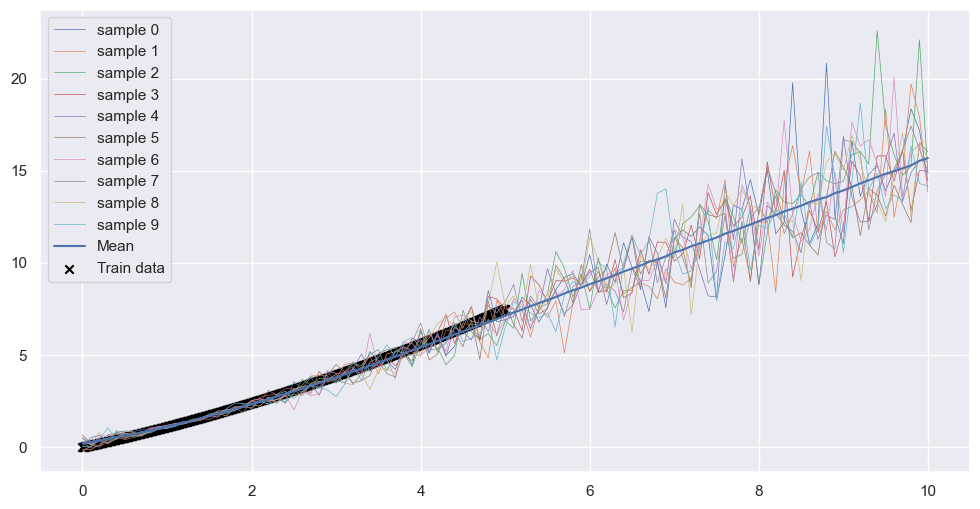

In [78]:
# plot 10 samples on the same figure
sns.set(rc={'figure.figsize':(12, 6)})
for i in range(10):
    plt.plot(x_sample, mu_arr[:, i], linewidth=0.5, label=f'sample {i}')
plt.plot(x_sample, np.mean(mu_arr, axis=1), linewidth=1.5, label='Mean')

# plot data
plt.scatter(X, y, marker='x', color='black', label='Train data')
plt.legend()
plt.show()

In [79]:
var_arr = np.exp(var_arr)

mean_hat = np.mean(mu_arr, axis=1)
var_hat = np.mean(var_arr + np.square(mu_arr), axis=1) - np.square(mean_hat)

std_hat = np.sqrt(var_hat)

In [80]:
uncertainty_aleatoric = np.mean(var_arr, axis=1)
uncertainty_epistemic = np.var(mu_arr, axis=1)

uncertainty_aleatoric_std = np.sqrt(uncertainty_aleatoric)
uncertainty_epistemic_std = np.sqrt(uncertainty_epistemic)

uncertainty_total = np.sqrt(uncertainty_aleatoric + uncertainty_epistemic)

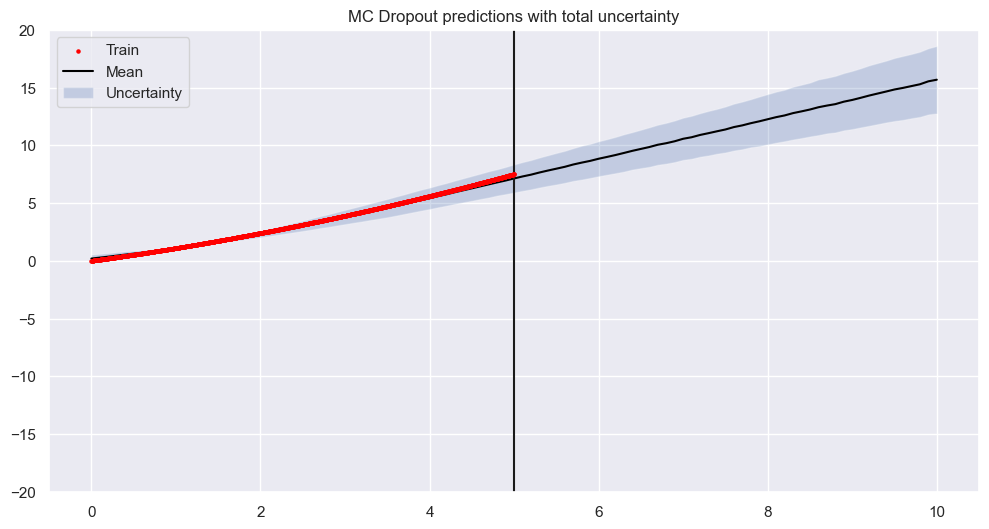

In [81]:
# plot predictions with confidence intervals
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")

plt.fill_between(x_sample, mean_hat - uncertainty_total, mean_hat + uncertainty_total, alpha=0.25, label='Uncertainty')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('MC Dropout predictions with total uncertainty')
plt.show()

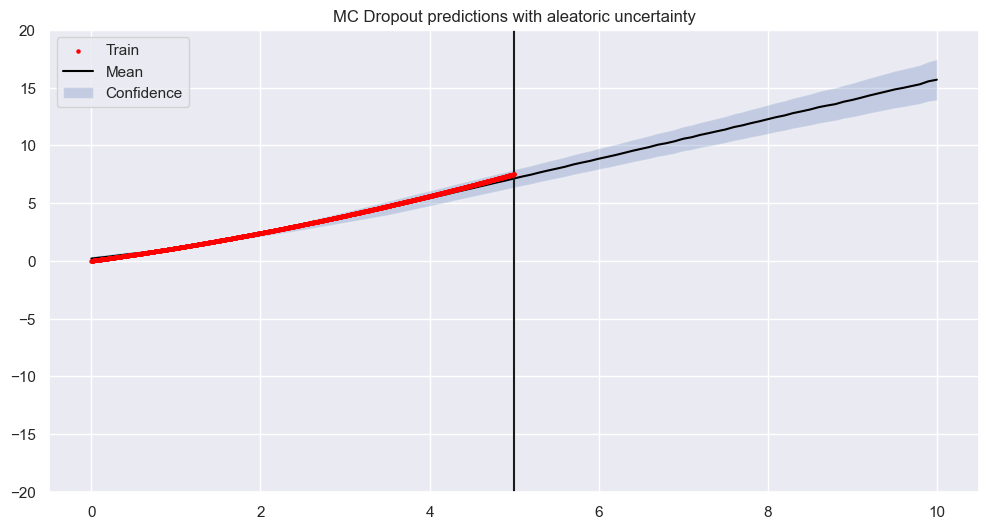

In [82]:
# plot predictions with confidence intervals, aleatoric uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label='Confidence')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('MC Dropout predictions with aleatoric uncertainty')
plt.show()

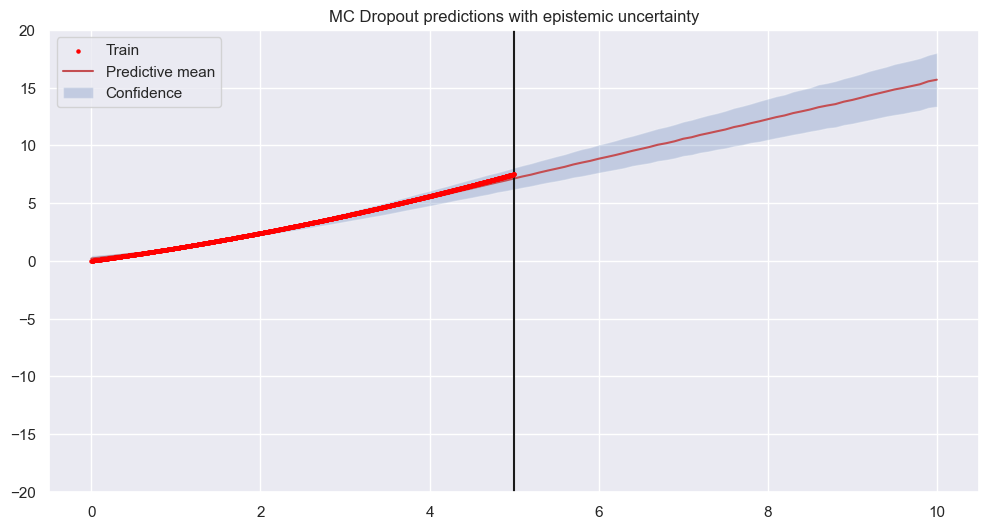

In [83]:
# plot predictions with confidence intervals, epistemic uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_epistemic_std, mean_hat + uncertainty_epistemic_std, alpha=0.25, label='Confidence')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('MC Dropout predictions with epistemic uncertainty')
plt.show()

In [84]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)


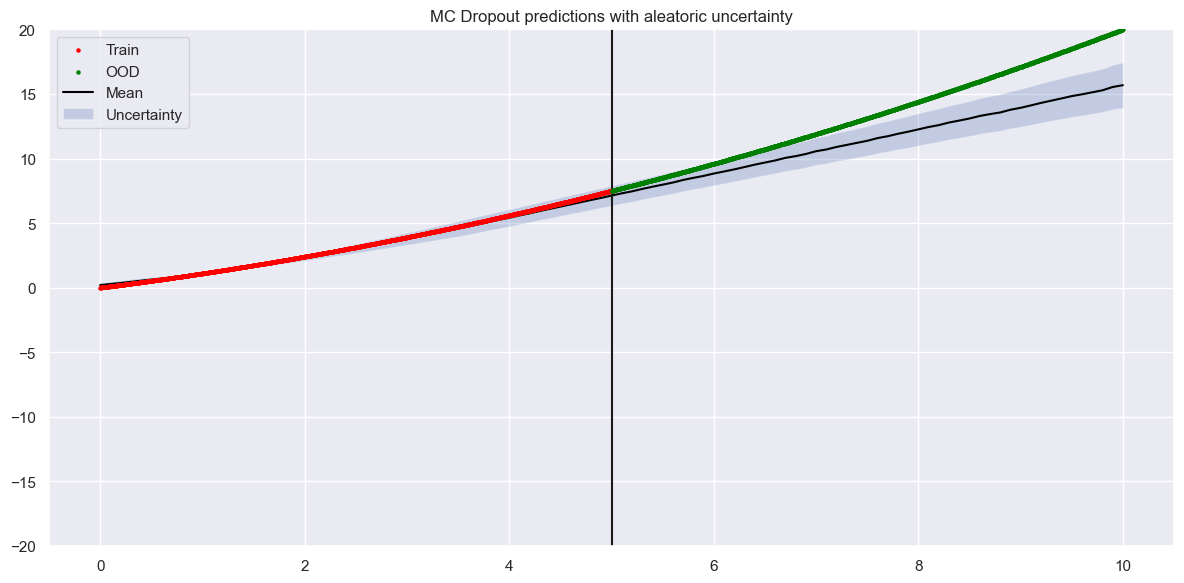

In [88]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, mean_hat, color="black", label="Mean")
plt.fill_between(x_sample, mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('MC Dropout predictions with aleatoric uncertainty')
plt.tight_layout()
plt.show()

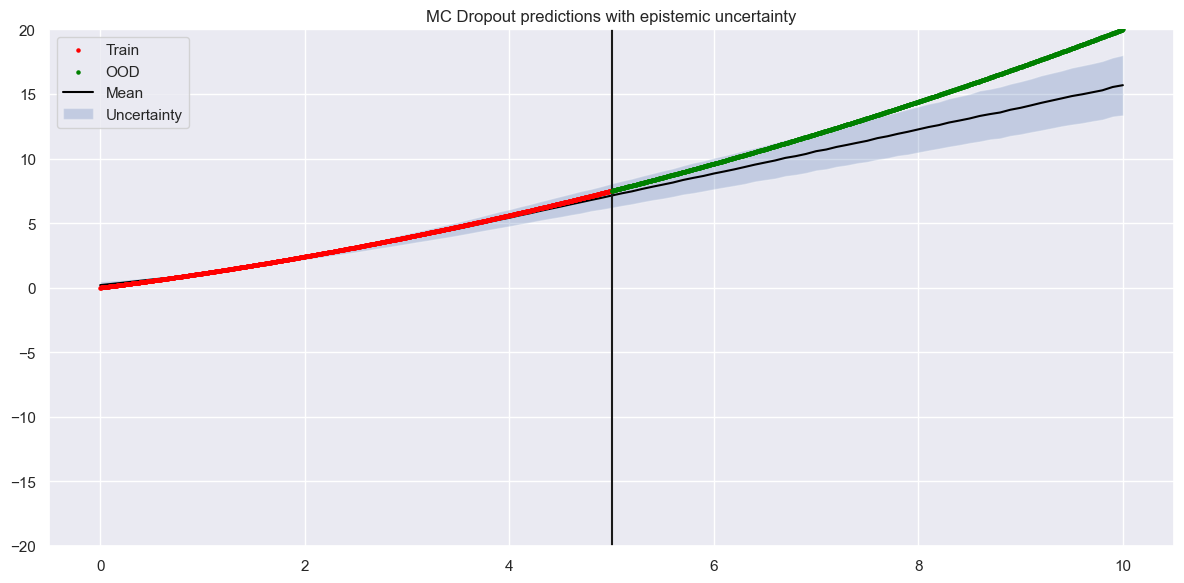

In [89]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, mean_hat, color="black", label="Mean")
plt.fill_between(x_sample, mean_hat - uncertainty_epistemic_std, mean_hat + uncertainty_epistemic_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('MC Dropout predictions with epistemic uncertainty')
plt.tight_layout()
plt.show()

## II. Splitting Aleatoric and Epistemic Uncertainty using Ensemble

### II.1. Ensemble implementation

In [37]:
class Simple_net(nn.Module):
    def __init__(self, p: int = 0.25) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        
        # instead of outputting a single value, we output two values
        # the mean and the std of the distribution
        self.fc_mu = nn.Linear(32, 1)
        self.fc_sigma = nn.Linear(32, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        mu = self.fc_mu(x)
        var = self.fc_sigma(x)
        return mu, var

Setup some training parameters:

In [38]:
num_networks = 10

model_list = []
opt_list = []
criterions = []

for i in range(num_networks):
    model_list.append(Simple_net().to(device))
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = 0.001, betas=(0.9, 0.999)))
    criterions.append(nn.MSELoss())

In [39]:
for i in tqdm.tqdm(range(10_000)):
    for iter in range(num_networks):   
        # model_list[iter].train() 
        # create batch
        batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
        
        # forward pass
        mu_train, var_train = model_list[iter](batch_x)
        
        # positivity constraint
        # sigma_train_pos = torch.log(1 + torch.exp(sigma_train)) + 1e-6
        
        # compute loss
        loss = torch.mean(
            0.5 * var_train + \
            0.5 * (torch.square(batch_y - mu_train)/torch.exp(var_train))) + 1
        
        # zero grad
        opt_list[iter].zero_grad()
    
        # backward pass
        loss.backward()

        # step
        opt_list[iter].step()
    
    # print each 500 epochs
    if i % 200 == 0:
        print(f"Epoch: {i}, train loss: {loss.item():.4f}")

  0%|          | 2/10000 [00:00<27:11,  6.13it/s]

Epoch: 0, train loss: 3.1783


  2%|▏         | 202/10000 [00:23<21:14,  7.69it/s]

Epoch: 200, train loss: 1.1845


  4%|▍         | 401/10000 [00:48<21:26,  7.46it/s]

Epoch: 400, train loss: 0.3127


  6%|▌         | 602/10000 [01:15<15:35, 10.04it/s]

Epoch: 600, train loss: 0.5300


  8%|▊         | 802/10000 [01:35<15:06, 10.15it/s]

Epoch: 800, train loss: 1.0497


 10%|█         | 1002/10000 [01:55<14:49, 10.11it/s]

Epoch: 1000, train loss: 0.5355


 12%|█▏        | 1203/10000 [02:15<14:24, 10.18it/s]

Epoch: 1200, train loss: 1.4725


 14%|█▍        | 1403/10000 [02:37<14:42,  9.75it/s]

Epoch: 1400, train loss: 0.8049


 16%|█▌        | 1603/10000 [02:58<13:27, 10.39it/s]

Epoch: 1600, train loss: 0.2836


 18%|█▊        | 1802/10000 [03:18<13:07, 10.41it/s]

Epoch: 1800, train loss: 0.7571


 20%|██        | 2002/10000 [03:41<13:47,  9.66it/s]

Epoch: 2000, train loss: 0.6132


 22%|██▏       | 2202/10000 [04:03<12:49, 10.13it/s]

Epoch: 2200, train loss: 1.0029


 24%|██▍       | 2402/10000 [04:23<12:29, 10.13it/s]

Epoch: 2400, train loss: 0.7190


 26%|██▌       | 2603/10000 [04:44<12:16, 10.04it/s]

Epoch: 2600, train loss: -0.1048


 28%|██▊       | 2802/10000 [05:07<12:24,  9.67it/s]

Epoch: 2800, train loss: 0.1154


 30%|███       | 3002/10000 [05:27<11:20, 10.28it/s]

Epoch: 3000, train loss: 0.6996


 32%|███▏      | 3202/10000 [05:47<11:08, 10.17it/s]

Epoch: 3200, train loss: 0.4236


 34%|███▍      | 3402/10000 [06:06<10:39, 10.32it/s]

Epoch: 3400, train loss: 0.6374


 36%|███▌      | 3602/10000 [06:25<10:16, 10.37it/s]

Epoch: 3600, train loss: 0.5273


 38%|███▊      | 3802/10000 [06:45<10:00, 10.33it/s]

Epoch: 3800, train loss: 1.2092


 40%|████      | 4002/10000 [07:04<09:37, 10.39it/s]

Epoch: 4000, train loss: 0.7717


 42%|████▏     | 4202/10000 [07:24<09:27, 10.23it/s]

Epoch: 4200, train loss: 0.9532


 44%|████▍     | 4402/10000 [11:19<11:43,  7.95it/s]   

Epoch: 4400, train loss: 0.6401


 46%|████▌     | 4604/10000 [11:40<06:01, 14.93it/s]

Epoch: 4600, train loss: 0.1924


 48%|████▊     | 4804/10000 [11:53<05:40, 15.27it/s]

Epoch: 4800, train loss: 0.5126


 50%|█████     | 5004/10000 [12:06<05:26, 15.32it/s]

Epoch: 5000, train loss: 0.4126


 52%|█████▏    | 5204/10000 [12:19<05:06, 15.63it/s]

Epoch: 5200, train loss: 0.6407


 54%|█████▍    | 5404/10000 [12:33<04:58, 15.38it/s]

Epoch: 5400, train loss: 0.6777


 56%|█████▌    | 5604/10000 [12:45<04:43, 15.52it/s]

Epoch: 5600, train loss: 1.0810


 58%|█████▊    | 5804/10000 [12:58<04:29, 15.58it/s]

Epoch: 5800, train loss: 0.7977


 60%|██████    | 6004/10000 [13:12<04:20, 15.31it/s]

Epoch: 6000, train loss: 0.9983


 62%|██████▏   | 6204/10000 [13:25<04:06, 15.42it/s]

Epoch: 6200, train loss: 0.5257


 64%|██████▍   | 6404/10000 [13:38<03:45, 15.97it/s]

Epoch: 6400, train loss: -0.2826


 66%|██████▌   | 6604/10000 [13:50<03:38, 15.53it/s]

Epoch: 6600, train loss: 0.7743


 68%|██████▊   | 6804/10000 [14:02<03:14, 16.42it/s]

Epoch: 6800, train loss: 0.1532


 70%|███████   | 7004/10000 [14:14<03:01, 16.54it/s]

Epoch: 7000, train loss: 0.5124


 72%|███████▏  | 7204/10000 [14:26<02:49, 16.53it/s]

Epoch: 7200, train loss: 0.5441


 74%|███████▍  | 7404/10000 [14:38<02:36, 16.59it/s]

Epoch: 7400, train loss: 0.1025


 76%|███████▌  | 7604/10000 [14:51<02:22, 16.79it/s]

Epoch: 7600, train loss: 0.7708


 78%|███████▊  | 7804/10000 [15:03<02:12, 16.61it/s]

Epoch: 7800, train loss: 0.5481


 80%|████████  | 8004/10000 [15:15<01:58, 16.80it/s]

Epoch: 8000, train loss: 0.4069


 82%|████████▏ | 8204/10000 [15:27<01:47, 16.74it/s]

Epoch: 8200, train loss: 0.2639


 84%|████████▍ | 8404/10000 [15:39<01:36, 16.62it/s]

Epoch: 8400, train loss: 1.3156


 86%|████████▌ | 8604/10000 [15:51<01:23, 16.68it/s]

Epoch: 8600, train loss: 0.4768


 88%|████████▊ | 8804/10000 [16:03<01:12, 16.56it/s]

Epoch: 8800, train loss: 0.5799


 90%|█████████ | 9004/10000 [16:15<01:00, 16.49it/s]

Epoch: 9000, train loss: 0.7514


 92%|█████████▏| 9204/10000 [16:27<00:47, 16.76it/s]

Epoch: 9200, train loss: 0.1365


 94%|█████████▍| 9404/10000 [16:39<00:35, 16.70it/s]

Epoch: 9400, train loss: 0.9523


 96%|█████████▌| 9604/10000 [16:51<00:23, 16.97it/s]

Epoch: 9600, train loss: 0.9006


 98%|█████████▊| 9804/10000 [17:03<00:11, 16.70it/s]

Epoch: 9800, train loss: 0.8744


100%|██████████| 10000/10000 [17:15<00:00,  9.66it/s]


In [40]:
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

# model_list[0].eval()

mu_arr = np.zeros([X_sample_tensor.shape[0], num_networks])
var_arr = np.zeros([X_sample_tensor.shape[0], num_networks])

with torch.no_grad():
    for i in range(num_networks):
        model_list[i].eval()
        
        mu_pred, var_pred = model_list[i](X_sample_tensor)
        # positivity constraint
        # sigma_pred_pos = torch.log(1 + torch.exp(sigma_pred)) + 1e-6
        
        mu_sample = mu_pred.cpu().detach().numpy()
        var_sample_log = var_pred.cpu().detach().numpy()
        
        
        mu_arr[:, i] = np.reshape(mu_sample, (X_sample_tensor.shape[0]))
        var_arr[:, i] = np.reshape(var_sample_log, (X_sample_tensor.shape[0]))

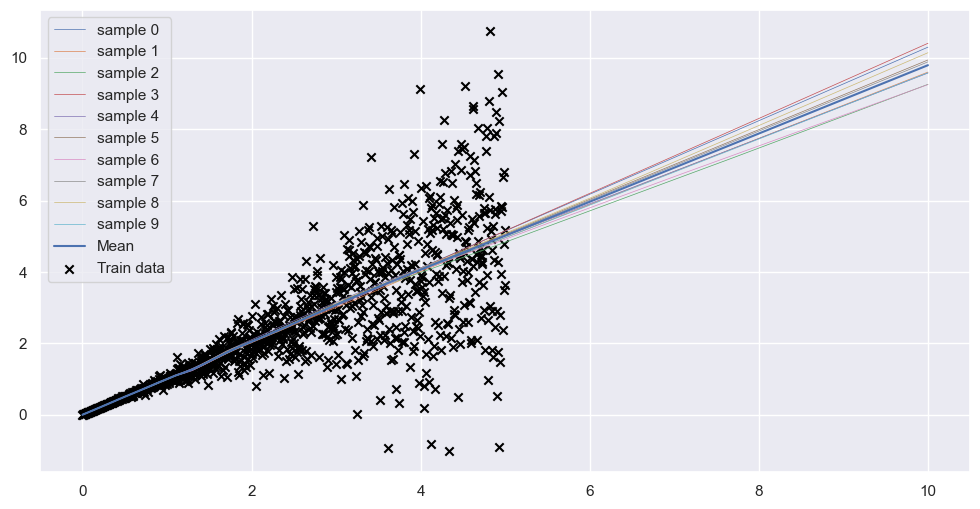

In [41]:
# plot 10 samples on the same figure
sns.set(rc={'figure.figsize':(12, 6)})
for i in range(10):
    plt.plot(x_sample, mu_arr[:, i], linewidth=0.5, label=f'sample {i}')
plt.plot(x_sample, np.mean(mu_arr, axis=1), linewidth=1.5, label='Mean')

# plot data
plt.scatter(X, y, marker='x', color='black', label='Train data')
plt.legend()
plt.show()

### II.2. Uncertainty estimation

In [42]:
var_arr = np.exp(var_arr)

mean_hat = np.mean(mu_arr, axis=1)
var_hat = np.mean(var_arr + np.square(mu_arr), axis=1) - np.square(mean_hat)

std_hat = np.sqrt(var_hat)

In [43]:
uncertainty_aleatoric = np.mean(var_arr, axis=1)
uncertainty_epistemic = np.var(mu_arr, axis=1)

uncertainty_aleatoric_std = np.sqrt(uncertainty_aleatoric)
uncertainty_epistemic_std = np.sqrt(uncertainty_epistemic)

uncertainty_total = np.sqrt(uncertainty_aleatoric + uncertainty_epistemic)

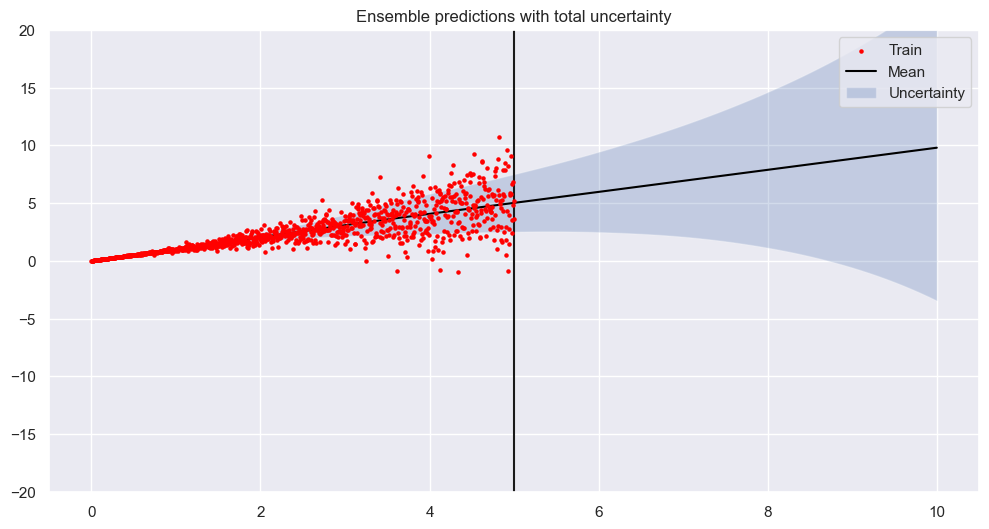

In [44]:
# plot predictions with confidence intervals
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")

plt.fill_between(x_sample, mean_hat - uncertainty_total, mean_hat + uncertainty_total, alpha=0.25, label='Uncertainty')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('Ensemble predictions with total uncertainty')
plt.show()

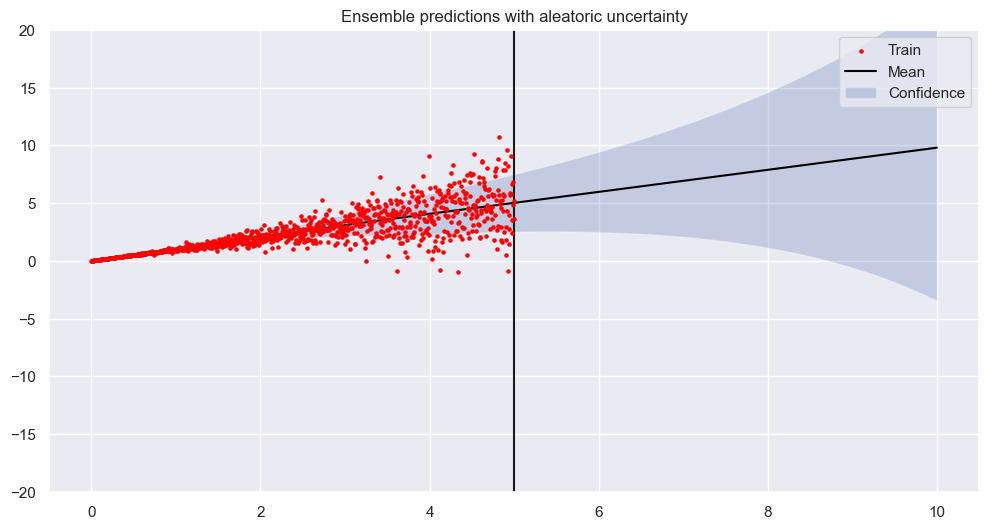

In [45]:
# plot predictions with confidence intervals, aleatoric uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label='Confidence')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('Ensemble predictions with aleatoric uncertainty')
plt.show()

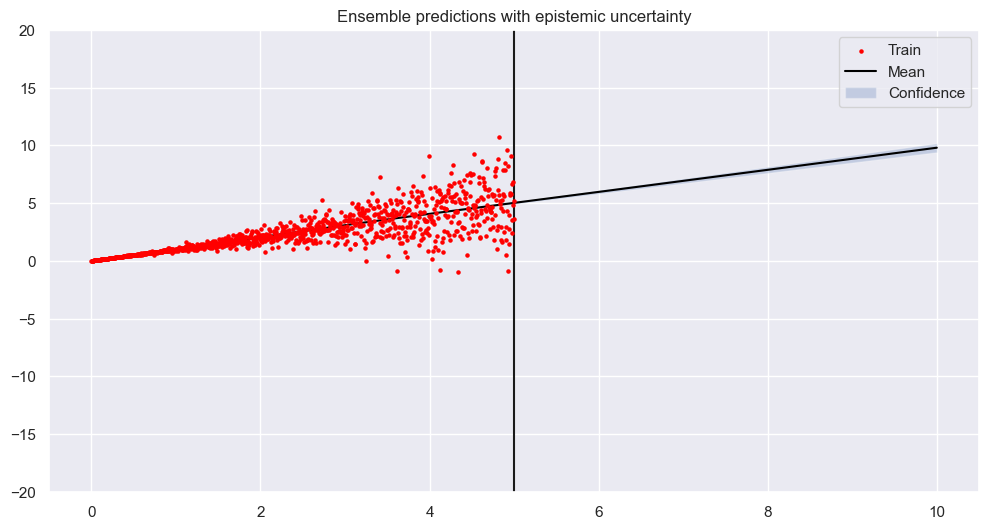

In [46]:
# plot predictions with confidence intervals, epistemic uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_epistemic_std, mean_hat + uncertainty_epistemic_std, alpha=0.25, label='Confidence')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('Ensemble predictions with epistemic uncertainty')
plt.show()

In [47]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

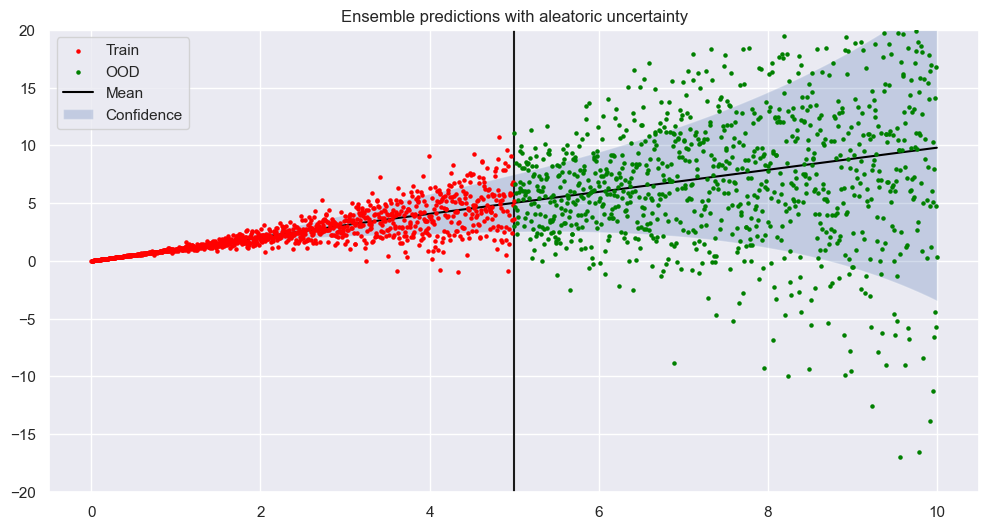

In [48]:
# plot predictions with confidence intervals, aleatoric uncertainty only
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(X_sample, mean_hat, color="black", label="Mean")
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label='Confidence')
plt.ylim([-20, 20])
plt.axvline(x=5, color='k')
plt.legend()
plt.title('Ensemble predictions with aleatoric uncertainty')
plt.show()